## Imports

In [1]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-3uscwia7
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-3uscwia7
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 839413b8767349afc62a2fbf824ec4147d57f634
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 

In [2]:
import os
import cv2
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch.optim import lr_scheduler

# Loading data
The dataset used for this training is from [Landslide4Sense](https://github.com/iarai/Landslide4Sense-2022) competition. It is a set of:
 - train images + segmentation masks
 - validation images + segmentation masks
 - test images + segmentation masks

In [3]:
DATA_DIR = "/kaggle/input/landslide4sense-2022/Landslide4Sense_2022/"

x_train_dir = os.path.join(DATA_DIR, "train", "img")
y_train_dir = os.path.join(DATA_DIR, "train", "mask")

x_valid_dir = os.path.join(DATA_DIR, "valid", "img")
y_valid_dir = os.path.join(DATA_DIR, "valid", "mask")

x_test_dir = os.path.join(DATA_DIR, "test", "img")
y_test_dir = os.path.join(DATA_DIR, "test", "mask")

## Dataloader
Writing helper class for data extraction, tranformation and preprocessing
https://pytorch.org/docs/stable/data

In [4]:
class Landslide4SenseDataset(BaseDataset):
    """
    Dataset class for binary segmentation of landslide-affected areas using multidimensional geospatial data.

    Args:
        images_dir (str): Path to the folder containing input HDF5 image files.
        masks_dir (str): Path to the folder containing corresponding HDF5 binary mask files (0 = background, 255 = landslide area).
    """

    def __init__(self, images_dir, masks_dir):
        # Get list of all file IDs from the images directory
        self.ids = os.listdir(images_dir)
        
        # Construct full paths for images and masks
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # Precomputed mean and std for each of the 14 image channels (for normalization)
        self.mean = [-0.4914, -0.3074, -0.1277, -0.0625, 0.0439, 0.0803, 0.0644, 0.0802, 0.3000, 0.4082, 0.0823, 0.0516, 0.3338, 0.7819]
        self.std =  [0.9325, 0.8775, 0.8860, 0.8869, 0.8857, 0.8418, 0.8354, 0.8491, 0.9061, 1.6072, 0.8848, 0.9232, 0.9018, 1.2913]

    def __getitem__(self, i):
        """
        Load and return one image-mask pair with preprocessing.

        Returns:
            image (np.ndarray): Normalized input image with shape (C, H, W).
            label (np.ndarray): Binary mask with shape (1, H, W).
        """

        # Load image data from HDF5 file
        with h5py.File(self.images_fps[i], 'r') as hf:
            image = hf['img'][:]

        # Load corresponding mask data from HDF5 file
        with h5py.File(self.masks_fps[i], 'r') as hf:
            label = hf['mask'][:]

        # Convert image and label to float32 numpy arrays
        image = np.asarray(image, np.float32)
        label = np.asarray(label, np.float32)

        # Rearrange image dimensions from (H, W, C) to (C, H, W) for PyTorch
        image = image.transpose((-1, 0, 1))

        # Add channel dimension to label to make shape (1, H, W)
        label = np.expand_dims(label, axis=0)

        # Normalize each channel of the image using precomputed mean and std
        for i in range(len(self.mean)):
            image[i, :, :] -= self.mean[i]
            image[i, :, :] /= self.std[i]

        return image.copy(), label.copy()

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        return len(self.ids)

In [9]:
dataset = Landslide4SenseDataset(x_train_dir, y_train_dir)

In [10]:
train_dataset = Landslide4SenseDataset(x_train_dir, y_train_dir)
valid_dataset = Landslide4SenseDataset(x_valid_dir, y_valid_dir)
test_dataset = Landslide4SenseDataset(x_test_dir, y_test_dir)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 3799
Valid dataset size: 245
Test dataset size: 800


## Hyperparameters

In [75]:
EPOCHS = 5
OUT_CLASSES = 1
BATCH = 32

In [76]:
train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=4)

T_MAX = EPOCHS * len(train_loader)

In [59]:
def normalize_channel(channel):
    ch = channel.copy()
    ch = ch - ch.min()
    ch = ch / (ch.max() + 1e-6)
    return ch

def show_multiple_samples(dataset, indices=[0, 1, 2, 3, 4]):
    num_samples = len(indices)
    num_bands = 13  # 12 bands + RGB + mask

    fig, axes = plt.subplots(num_samples, num_bands, figsize=(num_bands * 3, num_samples * 3))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # ensure 2D shape

    for row, idx in enumerate(indices):
        image, mask = dataset[idx]
        mask = mask.squeeze()

        # Extract and normalize channels
        aerosol = normalize_channel(image[0])         # B1
        blue = normalize_channel(image[1])            # B2
        green = normalize_channel(image[2])           # B3
        red = normalize_channel(image[3])             # B4
        rgb = np.stack([red, green, blue], axis=-1)   # RGB Composite

        re1 = normalize_channel(image[4])             # B5
        re2 = normalize_channel(image[5])             # B6
        re3 = normalize_channel(image[6])             # B7
        nir = normalize_channel(image[7])             # B8
        water_vapour = normalize_channel(image[8])    # B9
        cirrus = normalize_channel(image[9])          # B10
        swir1 = normalize_channel(image[10])          # B11
        swir2 = normalize_channel(image[11])          # B12
        slope = normalize_channel(image[12])          # B13
        dem = normalize_channel(image[13])            # B14

        # List of (title, image, colormap)
        channels = [
            ("RGB (B4,B3,B2)", rgb, None),
            ("Aerosol (B1)", aerosol, 'Blues'),
            ("RE1 (B5)", re1, 'Greens'),
            ("RE2 (B6)", re2, 'YlGn'),
            ("RE3 (B7)", re3, 'YlGnBu'),
            ("NIR (B8)", nir, 'inferno'),
            ("WV (B9)", water_vapour, 'PuBu'),
            ("Cirrus (B10)", cirrus, 'bone'),
            ("SWIR1 (B11)", swir1, 'magma'),
            ("SWIR2 (B12)", swir2, 'magma'),
            ("Slope (B13)", slope, None),
            ("DEM (B14)", dem, None),
            ("Mask", mask, 'gray')
        ]

        # Plot each band
        for col, (title, img, cmap) in enumerate(channels):
            ax = axes[row, col]
            if title == "RGB (B4,B3,B2)":
                ax.imshow(img)
            else:
                ax.imshow(img, cmap=cmap)
            if row == 0:
                ax.set_title(title, fontsize=14)
            ax.axis('off')

    plt.tight_layout(pad=2)
    plt.savefig("landslide4sense_samples.png")
    plt.show()


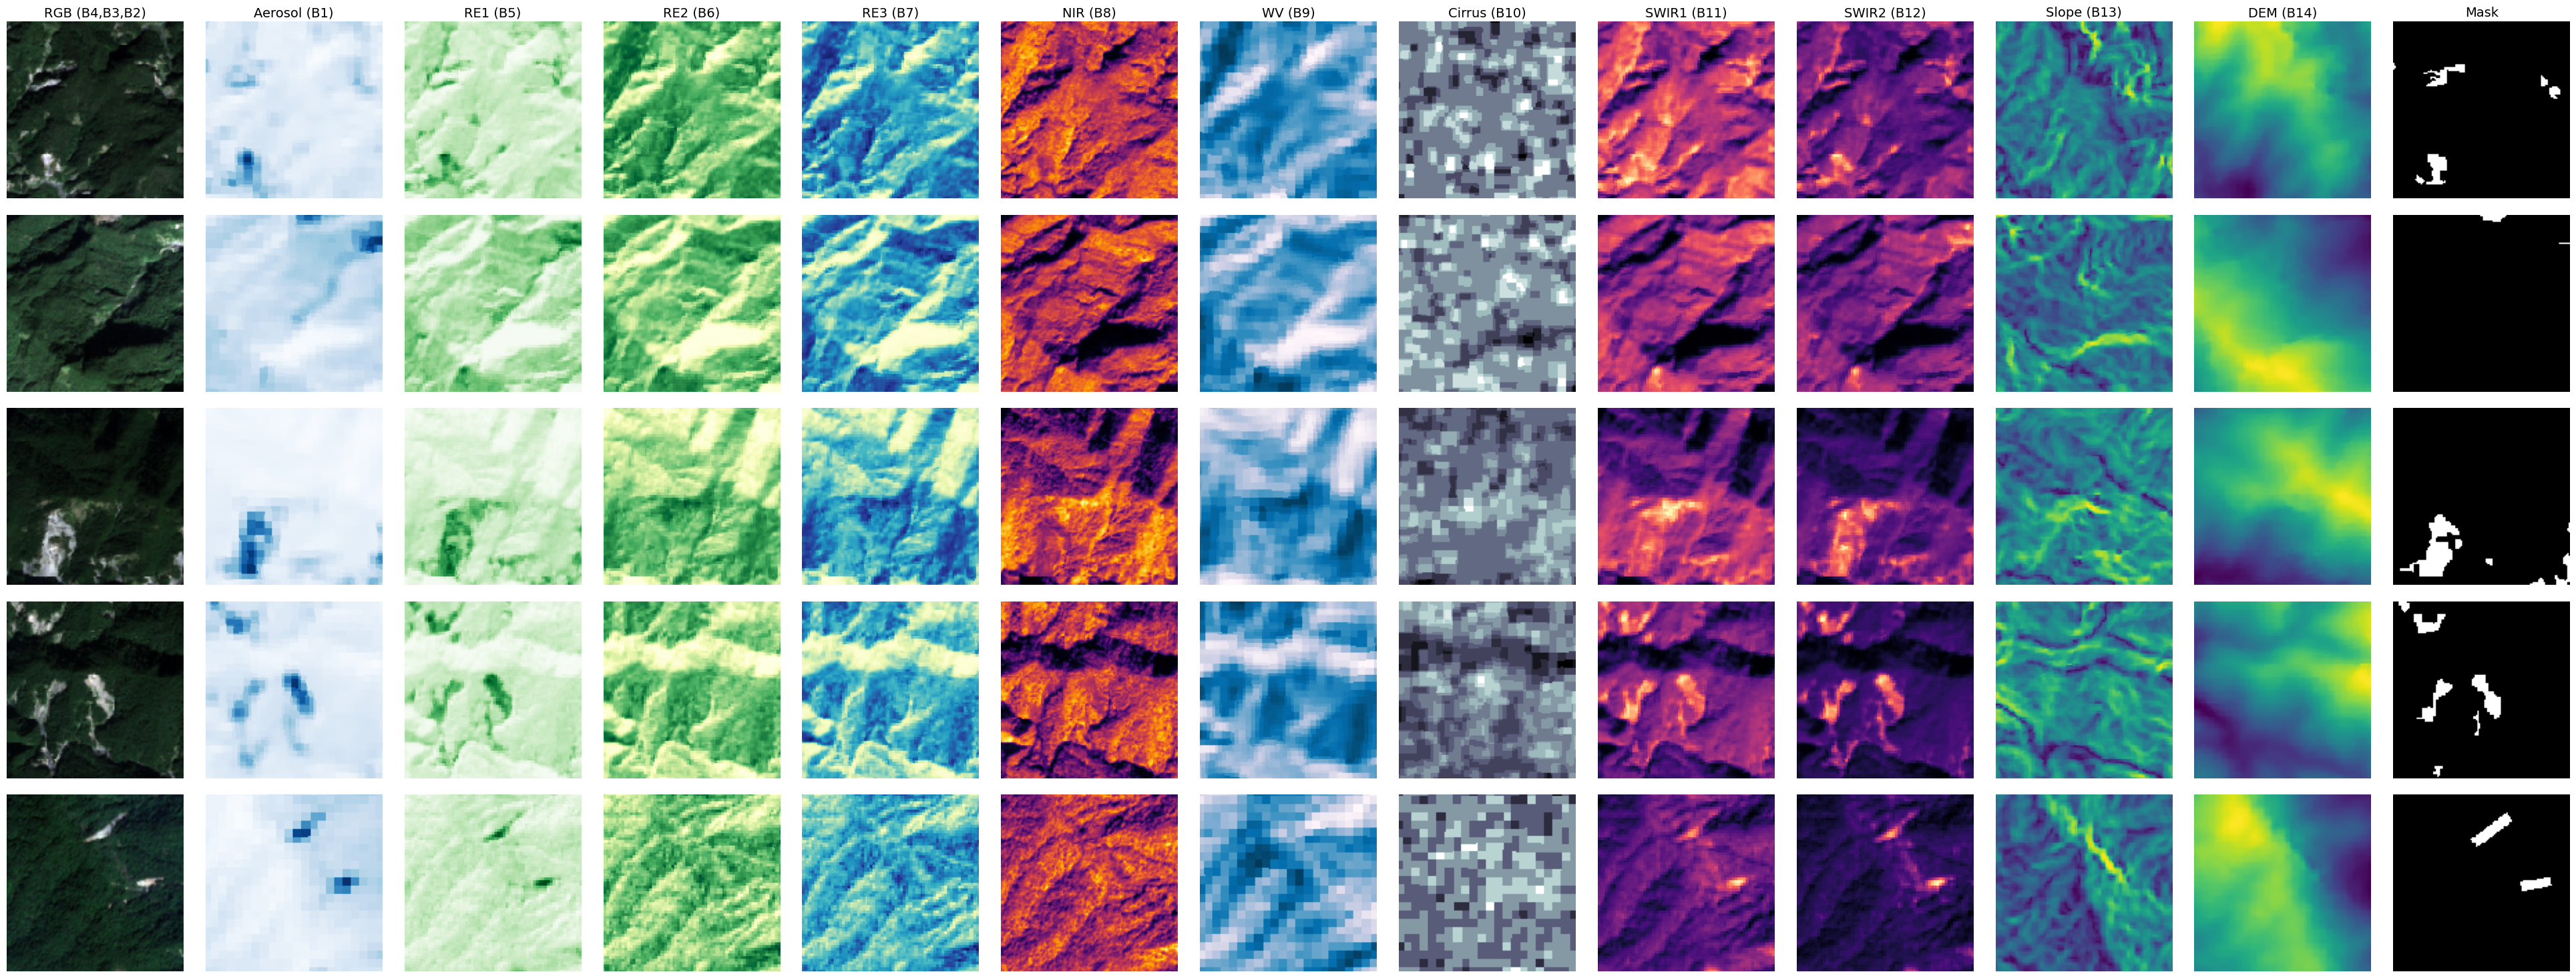

In [72]:
show_multiple_samples(train_dataset, indices=[4, 30, 80, 13, 24])

## Model Building
### 1. Unet

In [73]:
class LandslideMappingModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0


        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        # additional metrics
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
        
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_f1_score": f1_score,
            f"{stage}_f2_score": f2_score,
            f"{stage}_accuracy": accuracy,
            f"{stage}_recall": recall,
            f"{stage}_precision": precision,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

In [78]:
model = LandslideMappingModel("Unet", "resnext101_32x8d", encoder_weights= "imagenet", in_channels=14, out_classes=OUT_CLASSES)

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/356M [00:00<?, ?B/s]

## Training

In [79]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)

trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Evaluation

In [80]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_loader, verbose=True)
print(valid_metrics)

# run test dataset
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=True)
print(test_metrics)

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      valid_accuracy       │    0.9853196740150452     │
│     valid_dataset_iou     │    0.43904808163642883    │
│      valid_f1_score       │    0.6101923584938049     │
│      valid_f2_score       │     0.645230770111084     │
│    valid_per_image_iou    │    0.44594088196754456    │
│      valid_precision      │    0.5595496892929077     │
│       valid_recall        │    0.7774143218994141     │
└───────────────────────────┴───────────────────────────┘

[{'valid_per_image_iou': 0.44594088196754456, 'valid_dataset_iou': 0.43904808163642883, 'valid_f1_score': 0.6101923584938049, 'valid_f2_score': 0.645230770111084, 'valid_accuracy': 0.9853196740150452, 'valid_recall': 0.7774143218994141, 'valid_precision': 0.5595496892929077}]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9834558963775635     │
│     test_dataset_iou      │    0.4517267644405365     │
│       test_f1_score       │    0.6223303079605103     │
│       test_f2_score       │    0.6784131526947021     │
│    test_per_image_iou     │    0.43791189789772034    │
│      test_precision       │    0.5469691157341003     │
│        test_recall        │    0.7410802841186523     │
└───────────────────────────┴───────────────────────────┘

[{'test_per_image_iou': 0.43791189789772034, 'test_dataset_iou': 0.4517267644405365, 'test_f1_score': 0.6223303079605103, 'test_f2_score': 0.6784131526947021, 'test_accuracy': 0.9834558963775635, 'test_recall': 0.7410802841186523, 'test_precision': 0.5469691157341003}]


## Result Visualization

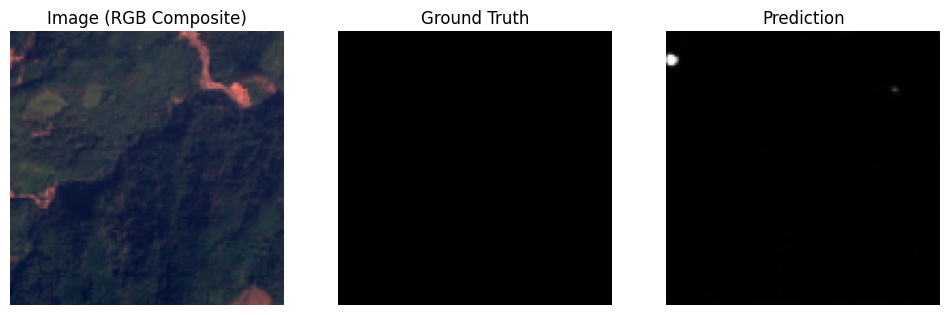

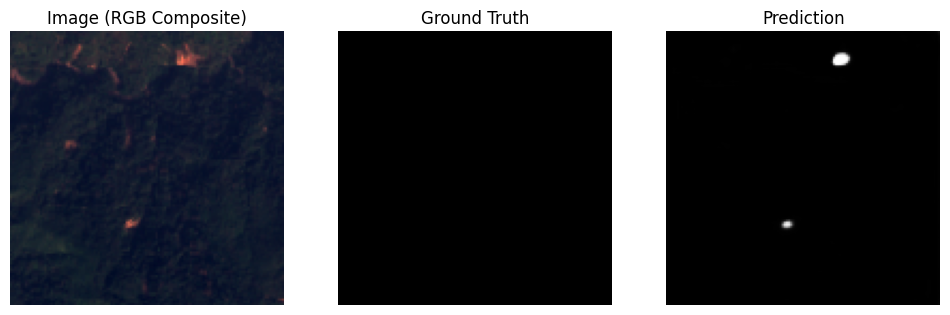

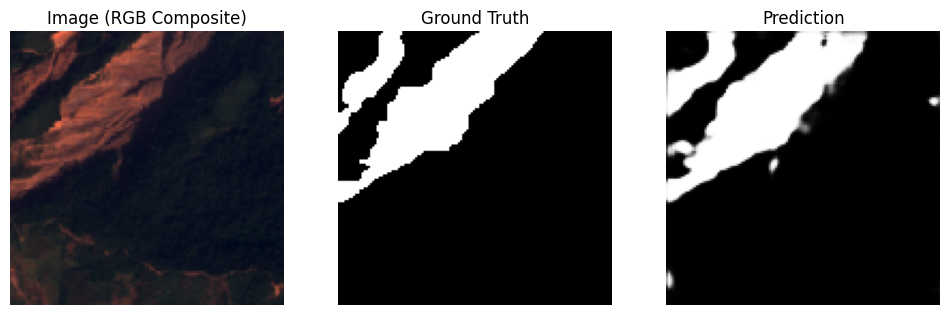

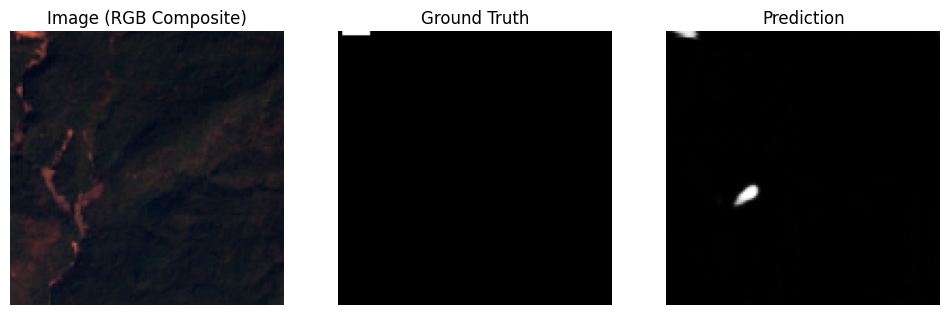

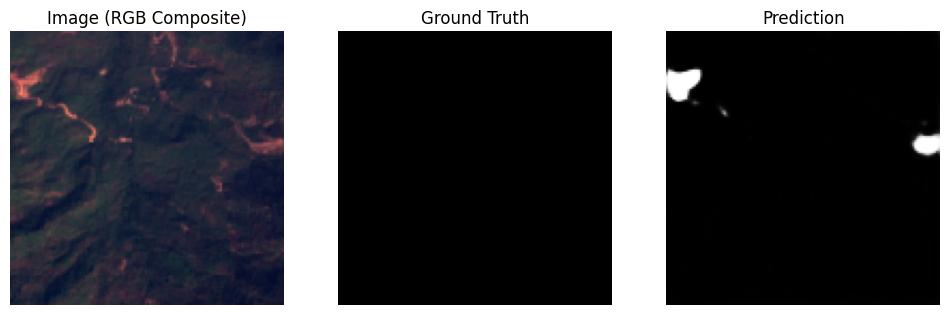

In [81]:
images, masks = next(iter(test_loader))
with torch.inference_mode():
    model.eval()
    logits = model(images)
pr_masks = logits.sigmoid()

for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx <= 4:
        # Create RGB composite from bands: B4 (Red), B3 (Green), B2 (Blue)
        rgb = image[[3, 2, 1], :, :]  # (3, 128, 128)
        
        # Normalize RGB for visualization (min-max normalization)
        rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(rgb.permute(1, 2, 0).numpy())
        plt.title("Image (RGB Composite)")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.squeeze().numpy(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.squeeze().numpy(), cmap='gray')
        plt.title("Prediction")
        plt.axis("off")

        plt.show()
    else:
        break

## Saving Model

In [82]:
# save the model
fmodel = model.model
fmodel.save_pretrained("saved-model-dir/unet/",  push_to_hub=False,  # <----------    push the model to the hub
    private=False,  # <----------    make the model private or or public
    dataset="landslide4sense",
    metrics={"mIoU": 0.95, "accuracy": 0.96},)

# load the model
restored_model = smp.from_pretrained("saved-model-dir/unet/")
print(restored_model)

Loading weights from local directory
Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(14, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU